Timothée Strouk

# Ex1: Onehot coding DNA

Write a function called **onehot_dna(dna_str)** that allows to encode a DNA segment where each base is encoded as a vector of all zeros except one in a specific position. The result of this function is an array numpy.  DNA is a long chain of repeating bases strung together. There are 4 bases: A, C, G, T. For example, "AACCCAAATCGGGGG" is a DNA segment.



For example, **onehot_dna('AAT')** should return

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]])






In [26]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.nn import Conv1d

In [2]:
def onehot_dna(dna_str):
  encoded = []
  DNA = ['A', 'C', 'G', 'T']
  for i in range(len(dna_str)):
    encoded.append([0, 0, 0, 0])
    encoded[i][DNA.index(dna_str[i])] = 1
  return np.array(encoded)

In [3]:
onehot_dna('AAT')

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]])

# Deep learning to classify Transcription Factor Biding


In the next exercises, we will learn how to use Deep learning to predict whether a segment of DNA does include or does not include a sit where JUND binds. (JUND is a particular transcription factor).

In this purpose, we will use data that is extracted from the chapter 6 of the book: 'Deep learning for the life science'. This book is written by B.Ramsundar, P.Eastman, P. Walters and V.Pande.


Data consist of DNA segments that have been split up from a full chromosome. Each segment is of 101 bases long and has been labeled to indicate whether it does or does not include a site where JUND binds to.


This is a binary classification problem.
The process of creating a PyTorch neural network binary classifier consists of several steps:

1. Prepare the training and test data

2. Implement a Dataset object to serve up the data

3. Design and implement a neural network

4. Write code to train the network

5. Write code to evaluate the model (the trained network)


# Ex 2:  Load Data

1. With the help of the joblib library, load the following files for training set:  **y_train.joblib**, **X_train.joblib**  and then store the results in variables **y_train, X_train** ,respectively.

2. Do the same thing for the test set: load  **y_test.joblib**, **X_test.joblib**  and then store the results in variables **y_test, X_test**, respectively.

3. What are the shape of **X_train** and **y_train** ? How many DNA segments are there in traning set ?

4. Display a DNA segment from **X_train** (using matplotlib.pyplot.imshow ).

5. Plot the histogram of **y_train** to see whether data is imbalanced or not.


In [10]:
X_train = joblib.load('data/X_train.joblib')
y_train = joblib.load('data/y_train.joblib')

In [11]:
X_test = joblib.load('data/X_test.joblib')
y_test = joblib.load('data/y_test.joblib')

In [13]:
print(f"Shape of X_train is: {X_train.shape}")
print(f"Shape of y_train is: {y_train.shape}")
print(f"{len(X_train)} DNA segments presents X_train")

Shape of X_train is: (4672, 101, 4)
Shape of y_train is: (4672, 1)
4672 DNA segments presents X_train


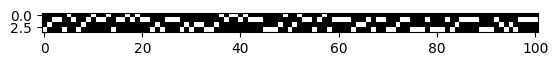

In [14]:
plt.imshow(X_train[0].T, cmap='gray')

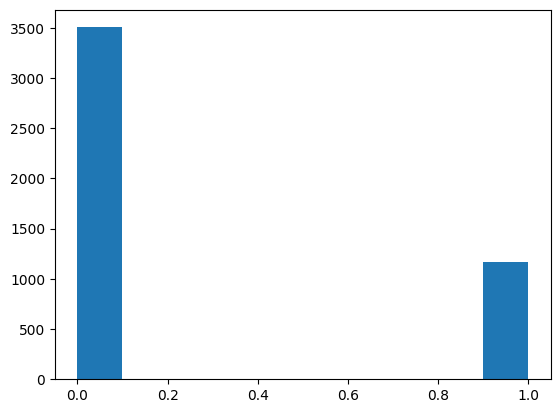

In [15]:
plt.hist(y_train)
plt.show()

# Ex 3: Convert numpy array to tensor pytorch

As you see in the previous exercise, **X_train** consists of 4672 segments. Each segment is encoded by 0 and 1 (one-hot encoding).


1. Convert numpy array **X_train**, **y_train** into pytorch tensor. Reshape **X_train** to (4672, 4, 101). Note that the type of **X_train** and **y_train** should be float.

2. Do the same thing for **X_test** and **y_test**


In [16]:
X_train = torch.from_numpy(X_train.transpose(0, 2, 1)).float()
y_train = torch.from_numpy(y_train).float()

In [17]:
X_test = torch.from_numpy(X_test.transpose(0, 2, 1)).float()
y_test = torch.from_numpy(y_test).float()

# Ex4: Create Dataset
In order to train a deep learning model with Pytorch, we need a pytorch dataset.
The DNADataset class below allows for creating a pytorch Dataset from DNA segments and their labels.

1. Using this class, create a dataset for training set. You should call it **train_dataset**

2. Create **Dataloader** from **train_dataset**. You should call it **train_loader**.

3. Do the same thing for the test set.

In [19]:
class DNADataset(torch.utils.data.Dataset):
    def __init__(self, dna, labels):
        self.labels = labels
        self.dna = dna


    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        label = self.labels[idx]
        frag_dna = self.dna[idx]

        sample = {'DNA': frag_dna, 'Class': label}

        return sample

In [22]:
train_dataset = DNADataset(X_train, y_train)

In [24]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [25]:
test_dataset = DNADataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Design and implement a convolutional neural network

Now, it's time to build your model. This is a binary classification problem. We can use a convolution neural network, just like an image classification problem. However, since the size of a DNA segment is (4, 101), we will use 1D convolution instead of 2D convolution.



Firstly, we will test how does a 1D convolution work on our data.



# EX 5: 1D Convolution

1. With the help of the torch.nn.Conv1d class, create a 1D convolutional layer. You need to choose values for the following parameters: **in_channels**, **out_channels**, **kernel_size**.


2. Apply this layer to **dna_seg** below. What is the size of the output ?


3. [Optional] Display the output by using matplotlib.pyplot.imshow




In [27]:
conv1d_instance = Conv1d(in_channels=4, out_channels=32, kernel_size=12)

In [28]:
output = conv1d_instance(X_train[:1])

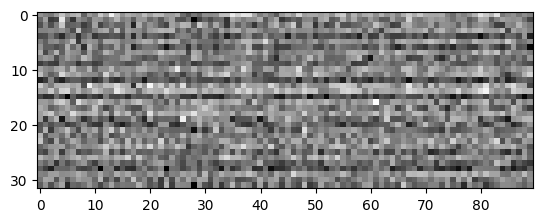

In [29]:
plt.imshow(output.detach().numpy()[0], cmap='gray')

# EX 6: Build a model

The following code is used to build a CNN model for a classification problem. This model consists of :

1. 3 layers of  1D-convolution. Each convolutional layer is followed by an activiation ReLu.

2. 2 Linear layers


Complete the lines # TODO below to finish the definition of this network.

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class DeepDNA(nn.Module):

  def __init__(self, sequence_length, num_class):
    """
    Parameters
    -----------
    sequence_length: int
    num_class: int

    """
    super(DeepDNA,self).__init__()

    self.sequence_length = sequence_length
    self.num_class = num_class

    self.conv1 = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

    self.lin1 = nn.Linear(self.sequence_length*64, 32)
    self.lin2 = nn.Linear(32, self.num_class)


  def forward(self, x):

    # 1/ pass the first convolutional layer
    #### TODO #####
    x = self.conv1(x)
    x = F.relu(x)

    # 2/ Pas the second convolutional layer
    #### TODO #####
    x = self.conv2(x)
    x = F.relu(x)

    # 3/ Pass the third convolution layer
    #### TODO #####
    x = self.conv3(x)
    x = F.relu(x)

    x = x.view(x.size(0), self.sequence_length*64)

    #### TODO #####
    x = self.lin1(x)
    x = F.relu(x)
    x = self.lin2(x)

    x = nn.Sigmoid()(x)

    return x


# Ex 7 Test the model


1. Create an instance of the DeepDNA class named **net**.

2. Print out the variable **net** to see detailed information about the model.

3. Pass **dna_seg** below to **net** in order to  test if your model **net** works well.

4. What is the size of the output ?



In [32]:
net = DeepDNA(101, 1)

In [33]:
print(net)

DeepDNA(
  (conv1): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (lin1): Linear(in_features=6464, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=1, bias=True)
)


In [34]:
output = net(X_train[:2, :, :])

In [35]:
print(f"The shape of the output is {output.shape}")

The shape of the output is torch.Size([2, 1])


# Ex 8: Define loss function and optimizer


1. Define an SGD optimizer for the model. You need to choose the learning rate for your model.

2. Define a Binary Cross Entropy (BCE) Loss  function.


In [36]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

In [51]:
criterion = nn.BCELoss()

# Ex 9: Training your model

The following function allows to train the model for one epoch. This function returns total loss per epoch.
Implement the training pass for this function.



The general process with PyTorch for one learning step consits of several steps:

1. Make a forward pass through the network
2. Use the network output to calculate the loss
3. Perform a backward pass through the network with loss.backward() to calculate the gradients
4. Take a step with the optimizer to update the weights



In [52]:
def train():
    net.train()
    train_loss = 0
    for batch_idx, sample in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(sample['DNA'])
        loss = criterion(output, sample['Class'])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()


# Ex 11: Accuracy Calculation

Write a function named **compute_num_correct_pred(y_prob, y_label)** that allows to compute the number of correct predictions. **y_prob** and **y_label** should be pytorch tensors.

For example,
y_prob = [[0.3],[0.4], [0.8], [0.7]].

y = [[0], [1], [1], [0]].

This function should return 2.

In [53]:
### TODO ####
def compute_num_correct_pred(y_prob, y_label):
    """
    Parameters
    ----------
    y_prob: torch.Tensor
    y_label: torch.Tensor

    Returns
    -------
    int
        number of correct predictions
    """
    y_pred = torch.round(y_prob)
    return torch.sum(y_pred == y_label).item()




The function below allows to calculate the accuracy of the model on dataset loader. Execute this function to see if you implemented the compute_num_correct_pred function correctly.

In [54]:
def test(loader):
  net.eval()

  correct = 0
  with torch.no_grad():
    for data in loader:
      dna = data['DNA']
      y = data['Class']

      out = net(dna)
      correct += compute_num_correct_pred(out, y)

  return correct / len(loader.dataset)

# Ex 12: Training the model

Write code to train your model on 10 epoches to see if everything is going well and then you can try to add more epoches.


In [55]:
for _ in range(100):
    train()

print(f"The accuracy on the test set is {test(test_loader)}")

The accuracy on the test set is 0.7448630136986302


# Ex13 (optional)

1. If we use torch.nn.BCEWithLogitsLoss(), what does we need to change to the definition of the model ?


2. The same question for torch.nn.CrossEntropyLoss() loss.  